In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls -lh /content/

total 8.0K
drwx------ 5 root root 4.0K Jul 23 21:01 drive
drwxr-xr-x 1 root root 4.0K Jul 22 13:37 sample_data


In [ ]:
import time
start = time.time()

!cp /content/drive/MyDrive/Df_Amz_all.csv /content/
end = time.time()

In [4]:
!ls -lh /content/

total 26M
-rw------- 1 root root  26M Jul 23 21:01 Df_Amz_all.csv
drwx------ 5 root root 4.0K Jul 23 21:01 drive
drwxr-xr-x 1 root root 4.0K Jul 22 13:37 sample_data


In [5]:
!pip install pandas numpy matplotlib seaborn hydroeval scikit-learn tensorflow

# 1.Preprocess data

In [18]:
import os
import re
from glob import glob
import random
import numpy as np
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import hydroeval as he
from hydroeval import evaluator, kge, nse
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


GLOBAL_OUTPUT_DIR = r"C:\Users\57484\Desktop\毕业设计 bristol\all_outputs"
#GLOBAL_OUTPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/outputs"
os.makedirs(GLOBAL_OUTPUT_DIR, exist_ok=True)
print("All charts/indicators will be saved to:", GLOBAL_OUTPUT_DIR)

random.seed(42)
# NumPy RNG
np.random.seed(42)
# TensorFlow RNG
tf.random.set_seed(42)

# For GPU determinism
os.environ['TF_DETERMINISTIC_OPS'] = '1'
tf.config.experimental.enable_op_determinism()

All charts/indicators will be saved to: C:\Users\57484\Desktop\毕业设计 bristol\all_outputs


df = pd.read_csv('/content/Df_Amz_all.csv')
df['date'] = pd.to_datetime(df['date'])

In [19]:
df = pd.read_csv(r"C:\Users\57484\Desktop\毕业设计 bristol\Dataset\Df_Amz_all.csv")
df['date'] = pd.to_datetime(df['date'])

In [20]:
df.head()

,Unnamed: 0,ID_CABra,date,prec_ref,Qmm,pet_pm,clim_tmin,clim_tmax,clim_pmm,clim_petmm_day,...,res_volume,res_regulation,hdisturb_index,catch_area,elev_mean,elev_min,elev_max,elev_gauge,catch_slope,catch_order
0,1,11,1980-10-01,0.062,1.473862,5.049,23.03,32.55,5.4,5.29,...,0.0,0.0,0.0,49871.585,409.64,64.42,1717.47,64.42,9.62,5
1,2,11,1980-10-02,1.846,1.773747,4.798,23.03,32.55,5.4,5.29,...,0.0,0.0,0.0,49871.585,409.64,64.42,1717.47,64.42,9.62,5
2,3,11,1980-10-03,0.041,1.697334,5.446,23.03,32.55,5.4,5.29,...,0.0,0.0,0.0,49871.585,409.64,64.42,1717.47,64.42,9.62,5
3,4,11,1980-10-04,0.030,1.687849,5.252,23.03,32.55,5.4,5.29,...,0.0,0.0,0.0,49871.585,409.64,64.42,1717.47,64.42,9.62,5
4,5,11,1980-10-05,0.221,1.556630,3.682,23.03,32.55,5.4,5.29,...,0.0,0.0,0.0,49871.585,409.64,64.42,1717.47,64.42,9.62,5


df = pd.read_csv(r"C:\Users\57484\Desktop\毕业设计 bristol\Df_Amz_ID_31\Df_Amz_all.csv")
df['date'] = pd.to_datetime(df['date'])

## 1.1Define function

In [4]:

LOOKBACK = 60
DATE_TRAIN = ("1980-10-01", "1998-09-30")
DATE_VAL = ("1998-10-01", "2004-09-30")
DATE_TEST = ("2004-10-01", "2010-09-30")
basin_ids = [31]

ALL_DYNAMIC = ["prec_ref", "pet_pm"]
ALL_STATIC = [
    "clim_tmin","clim_tmax","clim_pmm","clim_petmm_day",
    "aridity_index","q_mean_mm","runoff_coef","baseflow_index",
    "cover_urban_%","cover_crops_%","res_number","hdisturb_index",
    "catch_area","elev_mean","catch_slope","catch_order"
]
ALL_FEATURES = ALL_DYNAMIC + ALL_STATIC
TARGET = "Qmm"
selected_features = ALL_FEATURES
static_features = [f for f in selected_features if f not in ALL_DYNAMIC]


# Sub-basin screening and window adjustment
df_filtered = df[df["ID_CABra"].isin(basin_ids)].copy()
print("Sub-basin ID query:", df_filtered["ID_CABra"].unique())

Sub-basin ID query: [31]


In [5]:
#To ensure the window is complete, push the val/test start time forward by sequence_length - 1 day.
# The window is 60 days, and the prediction day already takes up one day, so push it forward another 59 days.
shift = LOOKBACK - 1

DATE_VAL_SHIFTED = (
    (datetime.strptime(DATE_VAL[0], "%Y-%m-%d") - timedelta(days=shift)).strftime("%Y-%m-%d"),
    DATE_VAL[1]
)
DATE_TEST_SHIFTED = (
    (datetime.strptime(DATE_TEST[0], "%Y-%m-%d") - timedelta(days=shift)).strftime("%Y-%m-%d"),
    DATE_TEST[1]
)

train_data = df_filtered[(df_filtered["date"] >= DATE_TRAIN[0]) & (df_filtered["date"] <= DATE_TRAIN[1])].copy()
val_data = df_filtered[(df_filtered["date"] >= DATE_VAL_SHIFTED[0]) & (df_filtered["date"] <= DATE_VAL_SHIFTED[1])].copy()
test_data = df_filtered[(df_filtered["date"] >= DATE_TEST_SHIFTED[0]) & (df_filtered["date"] <= DATE_TEST_SHIFTED[1])].copy()


In [6]:
scaler = StandardScaler()
scaler.fit(train_data[static_features])

train_data.loc[:, static_features] = scaler.transform(train_data[static_features])
val_data.loc[:, static_features] = scaler.transform(val_data[static_features])
test_data.loc[:, static_features] = scaler.transform(test_data[static_features])

train_std = train_data.copy()
val_std   = val_data.copy()
test_std  = test_data.copy()

In [7]:
def create_sequences(df, features, target, lookback):
    data = df[features].values
    labels = df[target].values
    n = len(df) - lookback + 1
    X = np.zeros((n, lookback, len(features)), dtype=np.float32)
    y = np.zeros(n, dtype=np.float32)
    for i in range(n):
        X[i] = data[i:i+lookback]
        y[i] = labels[i+lookback-1]
    return X, y

# For single or multiple basins
X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []

for basin in basin_ids:
    train_basin = train_data[train_data["ID_CABra"] == basin]
    val_basin = val_data[val_data["ID_CABra"] == basin]
    test_basin = test_data[test_data["ID_CABra"] == basin]

    X_tr, y_tr = create_sequences(train_basin, selected_features, TARGET, LOOKBACK)
    X_vl, y_vl = create_sequences(val_basin, selected_features, TARGET, LOOKBACK)
    X_te, y_te = create_sequences(test_basin, selected_features, TARGET, LOOKBACK)

    X_train_list.append(X_tr)
    y_train_list.append(y_tr)
    X_val_list.append(X_vl)
    y_val_list.append(y_vl)
    X_test_list.append(X_te)
    y_test_list.append(y_te)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)
X_val = np.concatenate(X_val_list, axis=0)
y_val = np.concatenate(y_val_list, axis=0)
X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

print("Shapes:",X_train.shape, y_train.shape, X_val.shape, y_val.shape,X_test.shape, y_test.shape)

Shapes: (6515, 60, 18) (6515,) (2192, 60, 18) (2192,) (2191, 60, 18) (2191,)


In [8]:
def check_data(data, name="Data"):
    if np.any(np.isnan(data)):
        raise ValueError(f"{name} contains NaN.")
    if np.any(np.isinf(data)):
        raise ValueError(f"{name} contains Inf.")
    print(f"{name} passed check. Shape: {data.shape}")

check_data(X_train, "X_train")
check_data(y_train, "y_train")
check_data(X_val, "X_val")
check_data(y_val, "y_val")

X_train passed check. Shape: (6515, 60, 18)
y_train passed check. Shape: (6515,)
X_val passed check. Shape: (2192, 60, 18)
y_val passed check. Shape: (2192,)


# 2.Build model

## 2.1 Original model

In [21]:
# Base Model Definition 

def make_model(lookback, num_feats, units, dp, lr):
    m = Sequential([
        LSTM(units, input_shape=(lookback, num_feats)),
        Dropout(dp),
        Dense(1),
        Activation('relu')
    ])
    m.compile(
        loss='mean_squared_error',
        optimizer=Adam(learning_rate=lr),
        metrics=['mean_squared_error']
    )
    return m



In [22]:
# Initial Single-Run Training 
num_units = len(ALL_FEATURES)
lookback   = LOOKBACK  # whatever you set above
lr0        = 1e-4
batch_size = 128
num_epochs = 100

model = make_model(lookback, num_units, units=num_units, dp=0.0, lr=lr0)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
ckpt = ModelCheckpoint(
    filepath=f"best_wts_ID31_{lookback}d.h5",
    monitor="val_loss", save_best_only=True, save_weights_only=True
)

# Print each layer’s name, output shape & parameter count
layer_names = [layer.name for layer in model.layers]
print("Layer names:", layer_names)

# Detailed summary of the model
model.summary()

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_vl, y_vl),
    epochs=num_epochs,
    batch_size=batch_size,
    callbacks=[es, ckpt],
    verbose=1
)

Layer names: ['lstm_31', 'dropout_31', 'dense_31', 'activation_31']
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 18)                2664      
                                                                 
 dropout_31 (Dropout)        (None, 18)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 19        
                                                                 
 activation_31 (Activation)  (None, 1)                 0         
                                                                 
Total params: 2683 (10.48 KB)
Trainable params: 2683 (10.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
51/51 [==============================] - 5s 53ms/step - loss: 5.7562 - 

Epoch 45/100
51/51 [==============================] - 2s 40ms/step - loss: 0.3880 - mean_squared_error: 0.3880 - val_loss: 0.4311 - val_mean_squared_error: 0.4311


In [13]:
# Print each layer’s name, output shape & parameter count
layer_names = [layer.name for layer in model.layers]
print("Layer names:", layer_names)

# Detailed summary of the model
model.summary()

Layer names: ['lstm', 'dropout', 'dense', 'activation']
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18)                2664      
                                                                 
 dropout (Dropout)           (None, 18)                0         
                                                                 
 dense (Dense)               (None, 1)                 19        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 2683 (10.48 KB)
Trainable params: 2683 (10.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
def concordance_correlation_coefficient(y_true, y_pred):
    """
    Concordance Correlation Coefficient with NaN handling.
    ρ_c = 2 cov(X,Y) / (σ_X² + σ_Y² + (μ_X - μ_Y)²)
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    mean_t = y_true.mean()
    mean_p = y_pred.mean()
    cov = np.mean((y_true - mean_t) * (y_pred - mean_p))
    var_t = y_true.var()
    var_p = y_pred.var()
    return (2 * cov) / (var_t + var_p + (mean_t - mean_p)**2 + 1e-8)

def evaluate_model(model, X_val, y_val, name="Validation"):
    """
    Evaluate model on validation set with KGE, NSE, CCC
    """
    y_pred = model.predict(X_val).flatten()
    
    # 自动计算
    kge_val = float(np.atleast_1d(evaluator(kge, y_pred, y_val)).flatten()[0])
    nse_val = float(np.atleast_1d(evaluator(nse, y_pred, y_val)).flatten()[0])
    ccc_val = float(concordance_correlation_coefficient(y_val, y_pred))

    print(f"[{name}] KGE: {kge_val:.3f}, NSE: {nse_val:.3f}, CCC: {ccc_val:.3f}")

    return {
        "KGE": kge_val,
        "NSE": nse_val,
        "CCC": ccc_val,
        "y_pred": y_pred  # Can be used for drawing
    }


## 2.2 Lookback window

In [19]:
# Evaluation of the Lookback Window
def run_lookback_study(train_std, val_std, target, feature_set, basin_id,
                       lookbacks=[15, 30, 60, 90, 180, 360, 720, 1080]):
    results = []
    for lb in lookbacks:
        print(f"\n Running lookback={lb}...")

        X_tr, y_tr = create_sequences(train_std, feature_set, target, lb)
        X_vl, y_vl = create_sequences(val_std,   feature_set, target, lb)

        num_units = len(feature_set)
        dropout = 0.2
        lr = 1e-4
        batch_size = 128
        num_epochs = 100

        model = make_model(lb, len(feature_set), units=num_units, dp=dropout, lr=lr)

        # save path
        ckpt_path = f"lookbackstudy_ID{basin_id}_{lb}d.h5"
        es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
        ckpt = ModelCheckpoint(filepath=ckpt_path,
                               monitor="val_loss", save_best_only=True, save_weights_only=True)

        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_vl, y_vl),
            epochs=num_epochs,
            batch_size=batch_size,
            callbacks=[es, ckpt],
            verbose=0
        )

        # predict
        y_pred = model.predict(X_vl).flatten()

        # Indicator calculation
        kge_val = float(np.atleast_1d(evaluator(kge, y_pred, y_vl)).flatten()[0])
        nse_val = float(np.atleast_1d(evaluator(nse, y_pred, y_vl)).flatten()[0])
        ccc_val = float(concordance_correlation_coefficient(y_vl, y_pred))

        # 
        print(f" Predicted vs Actual Sample (first 5):")
        print("Pred:", np.round(y_pred[:5], 3))
        print("True:", np.round(y_vl[:5], 3))

        # loss curve
        plt.figure()
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Val Loss')
        plt.title(f"Loss Curve - LB={lb}")
        plt.legend()
        plt.grid(True)
        loss_path = f"loss_curve_ID{basin_id}_{lb}d.png"
        plt.savefig(loss_path, dpi=150)
        plt.close()
        print(f"📉 Loss curve saved to {loss_path}")

        # Marking abnormal indicators
        if np.isnan(kge_val) or kge_val < 0.6:
            print(f" Warning: KGE is low or invalid at LB={lb} → KGE={kge_val:.3f}")
        if np.isnan(nse_val):
            print(f" Warning: NSE is NaN at LB={lb}")

        
        results.append({
            'lookback': lb,
            'KGE': kge_val,
            'NSE': nse_val,
            'CCC': ccc_val
        })

        print(f" LB={lb} | KGE={kge_val:.3f}, NSE={nse_val:.3f}, CCC={ccc_val:.3f} | Saved to: {ckpt_path}")

    df_result = pd.DataFrame(results)
    return df_result

In [20]:
print("Using features:", selected_features)
print("Number of features:", len(selected_features))

Using features: ['prec_ref', 'pet_pm', 'clim_tmin', 'clim_tmax', 'clim_pmm', 'clim_petmm_day', 'aridity_index', 'q_mean_mm', 'runoff_coef', 'baseflow_index', 'cover_urban_%', 'cover_crops_%', 'res_number', 'hdisturb_index', 'catch_area', 'elev_mean', 'catch_slope', 'catch_order']
Number of features: 18


In [21]:
df_lookback_result = run_lookback_study(
    train_std=train_std,
    val_std=val_std,
    target="Qmm",
    feature_set=selected_features,
    basin_id=basin_ids[0],
    lookbacks=[15, 30, 60, 90, 180, 360, 720, 1080]
)
print(df_lookback_result)



 Running lookback=15...
70/70 [==============================] - 1s 2ms/step
 Predicted vs Actual Sample (first 5):
Pred: [0.648 0.68  0.753 0.628 0.626]
True: [0.255 0.255 0.255 0.26  0.26 ]
📉 Loss curve saved to loss_curve_ID31_15d.png
 LB=15 | KGE=0.644, NSE=0.600, CCC=0.740 | Saved to: lookbackstudy_ID31_15d.h5

 Running lookback=30...
70/70 [==============================] - 1s 3ms/step
 Predicted vs Actual Sample (first 5):
Pred: [0.699 0.718 0.769 0.727 0.689]
True: [0.205 0.198 0.193 0.19  0.19 ]
📉 Loss curve saved to loss_curve_ID31_30d.png
 LB=30 | KGE=0.796, NSE=0.771, CCC=0.869 | Saved to: lookbackstudy_ID31_30d.h5

 Running lookback=60...
69/69 [==============================] - 1s 6ms/step
 Predicted vs Actual Sample (first 5):
Pred: [0.534 0.413 0.327 0.364 0.399]
True: [0.118 0.116 0.112 0.108 0.104]
📉 Loss curve saved to loss_curve_ID31_60d.png
 LB=60 | KGE=0.864, NSE=0.856, CCC=0.924 | Saved to: lookbackstudy_ID31_60d.h5

 Running lookback=90...
68/68 [==============

In [26]:
print(df_lookback_result)

   lookback       KGE       NSE       CCC
0        15  0.644476  0.600065  0.739846
1        30  0.795847  0.770891  0.869100
2        60  0.863538  0.855657  0.924426
3        90  0.933724  0.889511  0.946169
4       180  0.922586  0.921146  0.958321
5       360  0.879334  0.883234  0.944051
6       720  0.921741  0.906621  0.952266
7      1080  0.886725  0.911774  0.958252


In [ ]:
best_lookback = df_lookback_result.loc[df_lookback_result['KGE'].idxmax(), 'lookback']
print(f"Best Lookback Found: {best_lookback} days")

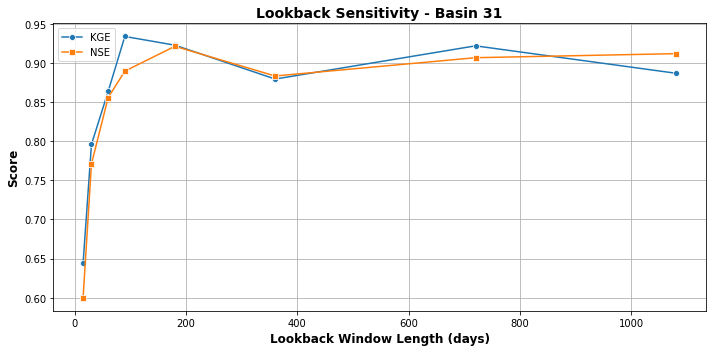

 Have saved：C:\Users\57484\Desktop\毕业设计 bristol\all_outputs\lookback_sensitivity_basin31.png


In [22]:
plt.figure(figsize=(10, 5))
sns.lineplot(x="lookback", y="KGE", data=df_lookback_result, marker="o", label="KGE")
sns.lineplot(x="lookback", y="NSE", data=df_lookback_result, marker="s", label="NSE")
plt.xlabel("Lookback Window Length (days)", fontsize=12, fontweight="bold")
plt.ylabel("Score", fontsize=12, fontweight="bold")
plt.title(f"Lookback Sensitivity - Basin {BASIN_ID}", fontsize=14, fontweight="bold")
plt.grid(True)
plt.legend()
plt.tight_layout()

fig_path = os.path.join(GLOBAL_OUTPUT_DIR, f"lookback_sensitivity_basin{BASIN_ID}.png")
plt.savefig(fig_path, dpi=300)
plt.show()
print(f" Have saved：{fig_path}")

In [ ]:
plt.figure(figsize=(12, 6))

for lb in [60, 90, 180]:
    X_vl_lb, y_vl_lb = create_sequences(val_std, selected_features, TARGET, lb)
    full_dates = val_std['date'].reset_index(drop=True)
    dates_val_lb = pd.to_datetime(full_dates.iloc[lb-1 : lb-1 + len(y_vl_lb)]).values

    model = make_model(lb, len(selected_features), units=len(selected_features), dp=0.2, lr=1e-4)
    model.load_weights(f"lookbackstudy_ID{BASIN_ID}_{lb}d.h5")  

    y_pred_lb = model.predict(X_vl_lb).flatten()
    plt.plot(dates_val_lb, y_pred_lb, label=f'lookback={lb}')

# Add observations
X_90, y_obs = create_sequences(val_std, selected_features, TARGET, 90)
dates_obs = pd.to_datetime(full_dates.iloc[90-1 : 90-1 + len(y_obs)]).values
plt.plot(dates_obs, y_obs, 'k--', linewidth=2, label='Observed')


plt.xlabel('Date')
plt.ylabel('Discharge (Qmm)')
#plt.title('Validation Prediction under Different Lookbacks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, f"lookback_prediction_trend_basin{BASIN_ID}.png"), dpi=300)
plt.show()


65/65 [==============================] - 2s 14ms/step


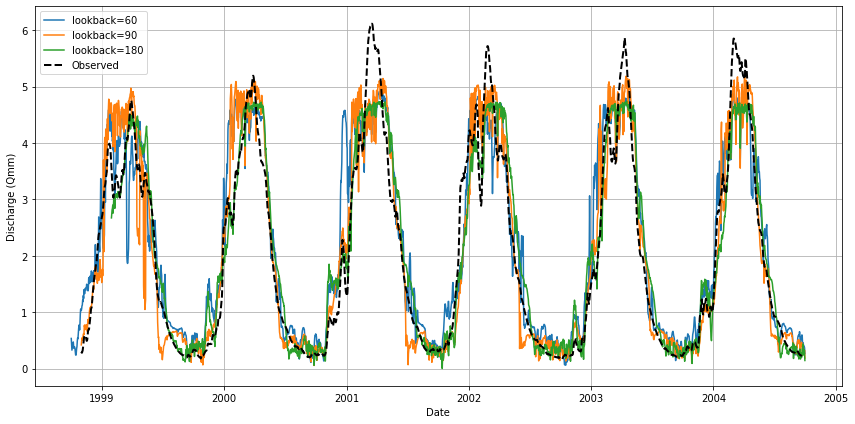

In [24]:
plt.figure(figsize=(12, 6))

for lb in [60, 90, 180]:
    X_vl_lb, y_vl_lb = create_sequences(val_std, selected_features, TARGET, lb)
    full_dates = val_std['date'].reset_index(drop=True)
    dates_val_lb = pd.to_datetime(full_dates.iloc[lb-1 : lb-1 + len(y_vl_lb)]).values

    model = make_model(lb, len(selected_features), units=len(selected_features), dp=0.2, lr=1e-4)
    model.load_weights(f"lookbackstudy_ID{BASIN_ID}_{lb}d.h5")  

    y_pred_lb = model.predict(X_vl_lb).flatten()
    plt.plot(dates_val_lb, y_pred_lb, label=f'lookback={lb}')


X_90, y_obs = create_sequences(val_std, selected_features, TARGET, 90)
dates_obs = pd.to_datetime(full_dates.iloc[90-1 : 90-1 + len(y_obs)]).values
plt.plot(dates_obs, y_obs, 'k--', linewidth=2, label='Observed')

plt.xlabel('Date')
plt.ylabel('Discharge (Qmm)')
#plt.title('Validation Prediction under Different Lookbacks')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, f"lookback_prediction_trend_basin{BASIN_ID}.png"), dpi=300)
plt.show()


## 2.3 Grid search

In [25]:
results = []
repeat_times = 3    # Repeat each hyperparameter combination several times and take the average
best = {'mean_KGE': -np.inf}
best_ckpt = 'best_overall.h5'

# lookback=90
LOOKBACK = 90
X_tr_lb, y_tr_lb = create_sequences(train_std, ALL_FEATURES, TARGET, LOOKBACK)
X_vl_lb, y_vl_lb = create_sequences(val_std, ALL_FEATURES, TARGET, LOOKBACK)

for units in [18, 24, 36, 48]:
    for lr in [1e-3, 5e-4, 1e-4]:
        for dp in [0.1, 0.2]:
            kge_list = []
            for repeat in range(repeat_times):
                m = make_model(LOOKBACK, len(ALL_FEATURES), units, dp, lr)
                temp_ckpt = f"temp_{LOOKBACK}_{units}_{lr}_{dp}_{repeat}.h5"
                es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
                ck = ModelCheckpoint(temp_ckpt, monitor='val_loss',
                                     save_best_only=True, save_weights_only=True)

                m.fit(
                    X_tr_lb, y_tr_lb,
                    validation_data=(X_vl_lb, y_vl_lb),
                    epochs=30, batch_size=64,
                    callbacks=[es, ck], verbose=0
                )

                m.load_weights(temp_ckpt)
                y_pred = m.predict(X_vl_lb).flatten()
                kge = float(he.evaluator(he.kge, y_pred, y_vl_lb)[0])
                kge_list.append(kge)

            mean_kge = np.mean(kge_list)
            std_kge = np.std(kge_list)
            print(f"  units={units}, lr={lr}, dp={dp} → mean KGE={mean_kge:.4f} (±{std_kge:.4f})")

            results.append({
                'lookback': LOOKBACK,
                'units': units,
                'lr': lr,
                'dropout': dp,
                'mean_KGE': mean_kge,
                'std_KGE': std_kge
            })

            if mean_kge > best['mean_KGE']:
                best = {
                    'mean_KGE': mean_kge,
                    'std_KGE': std_kge,
                    'lookback': LOOKBACK,
                    'units': units,
                    'lr': lr,
                    'dropout': dp
                }
                shutil.copy(temp_ckpt, best_ckpt)

print("\n Best config found:")
print(best)

68/68 [==============================] - 1s 7ms/step
  units=18, lr=0.001, dp=0.1 → mean KGE=0.8959 (±0.0185)
68/68 [==============================] - 1s 7ms/step
  units=18, lr=0.001, dp=0.2 → mean KGE=0.8846 (±0.0215)
68/68 [==============================] - 1s 7ms/step
  units=18, lr=0.0005, dp=0.1 → mean KGE=0.8627 (±0.0123)
68/68 [==============================] - 1s 7ms/step
  units=18, lr=0.0005, dp=0.2 → mean KGE=0.8986 (±0.0042)
68/68 [==============================] - 1s 7ms/step
  units=18, lr=0.0001, dp=0.1 → mean KGE=0.8840 (±0.0211)
68/68 [==============================] - 1s 7ms/step
  units=18, lr=0.0001, dp=0.2 → mean KGE=0.9089 (±0.0148)
68/68 [==============================] - 1s 9ms/step
  units=24, lr=0.001, dp=0.1 → mean KGE=0.8902 (±0.0049)
68/68 [==============================] - 1s 8ms/step
  units=24, lr=0.001, dp=0.2 → mean KGE=0.9077 (±0.0029)
68/68 [==============================] - 1s 9ms/step
  units=24, lr=0.0005, dp=0.1 → mean KGE=0.9007 (±0.0125)
68/68

In [28]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('mean_KGE', ascending=False)
print(df_results)

    lookback  units      lr  dropout  mean_KGE   std_KGE
5         90     18  0.0001      0.2  0.908878  0.014841
7         90     24  0.0010      0.2  0.907706  0.002871
8         90     24  0.0005      0.1  0.900691  0.012463
3         90     18  0.0005      0.2  0.898618  0.004166
0         90     18  0.0010      0.1  0.895886  0.018547
6         90     24  0.0010      0.1  0.890198  0.004898
19        90     48  0.0010      0.2  0.885940  0.005571
10        90     24  0.0001      0.1  0.885235  0.010806
1         90     18  0.0010      0.2  0.884575  0.021473
15        90     36  0.0005      0.2  0.884209  0.014313
4         90     18  0.0001      0.1  0.884014  0.021065
9         90     24  0.0005      0.2  0.881463  0.012006
21        90     48  0.0005      0.2  0.880303  0.000791
11        90     24  0.0001      0.2  0.880032  0.017869
12        90     36  0.0010      0.1  0.878230  0.032438
13        90     36  0.0010      0.2  0.878155  0.024038
14        90     36  0.0005    

In [13]:
X_vl_lb, y_vl_lb = create_sequences(val_std, ALL_FEATURES, TARGET, LOOKBACK)

# Scan and save the model file
model_files = glob(f"temp_{LOOKBACK}_*.h5")

ccc_results = []

for file in model_files:
    # Extract model parameters
    match = re.search(rf'temp_{LOOKBACK}_(\d+)_([\d\.e-]+)_([\d\.]+)_(\d+).h5', file)
    if match:
        units = int(match.group(1))
        lr = float(match.group(2))
        dp = float(match.group(3))
        repeat = int(match.group(4))

      
        model = make_model(LOOKBACK, len(ALL_FEATURES), units, dp, lr)
        model.load_weights(file)

        # Predict and calculate CCC
        y_pred = model.predict(X_vl_lb).flatten()
        ccc = concordance_correlation_coefficient(y_vl_lb, y_pred)

        # save
        ccc_results.append({
            'units': units,
            'lr': lr,
            'dropout': dp,
            'repeat': repeat,
            'ccc': ccc
        })


df_ccc = pd.DataFrame(ccc_results)
summary = df_ccc.groupby(['units', 'lr', 'dropout'])['ccc'].agg(['mean', 'std']).reset_index()
print(summary)



69/69 [==============================] - 1s 8ms/step
    units      lr  dropout      mean       std
0      18  0.0001      0.1  0.927322  0.002347
1      18  0.0001      0.2  0.913736  0.007741
2      18  0.0005      0.1  0.924389  0.007420
3      18  0.0005      0.2  0.938716  0.003178
4      18  0.0010      0.1  0.934984  0.003755
5      18  0.0010      0.2  0.930665  0.003719
6      24  0.0001      0.1  0.925765  0.003543
7      24  0.0001      0.2  0.929401  0.003458
8      24  0.0005      0.1  0.931517  0.005398
9      24  0.0005      0.2  0.931653  0.001891
10     24  0.0010      0.1  0.938273  0.006494
11     24  0.0010      0.2  0.934379  0.003769
12     36  0.0001      0.1  0.932554  0.003106
13     36  0.0001      0.2  0.936746  0.001724
14     36  0.0005      0.1  0.940958  0.003685
15     36  0.0005      0.2  0.938665  0.008044
16     36  0.0010      0.1  0.939739  0.002338
17     36  0.0010      0.2  0.940246  0.002158
18     48  0.0001      0.1  0.929453  0.005722
19     

In [29]:
df_ccc = summary.rename(columns={'mean': 'mean_CCC', 'std': 'std_CCC'})

df_merged = pd.merge(df_results, df_ccc, on=['units', 'lr', 'dropout'])

print(df_merged)

df_merged.to_csv("merged_kge_ccc_results.csv", index=False)

    lookback  units      lr  dropout  mean_KGE   std_KGE  mean_CCC   std_CCC
0         90     18  0.0001      0.2  0.908878  0.014841  0.939553  0.005878
1         90     24  0.0010      0.2  0.907706  0.002871  0.961227  0.007848
2         90     24  0.0005      0.1  0.900691  0.012463  0.958574  0.002938
3         90     18  0.0005      0.2  0.898618  0.004166  0.943920  0.000327
4         90     18  0.0010      0.1  0.895886  0.018547  0.958278  0.010472
5         90     24  0.0010      0.1  0.890198  0.004898  0.952158  0.011552
6         90     48  0.0010      0.2  0.885940  0.005571  0.965662  0.001714
7         90     24  0.0001      0.1  0.885235  0.010806  0.942766  0.005015
8         90     18  0.0010      0.2  0.884575  0.021473  0.951969  0.014426
9         90     36  0.0005      0.2  0.884209  0.014313  0.954016  0.010022
10        90     18  0.0001      0.1  0.884014  0.021065  0.941451  0.008775
11        90     24  0.0005      0.2  0.881463  0.012006  0.948040  0.006601

In [34]:
print("Best Params Found:")
print(best)

Best Params Found:
{'mean_KGE': 0.9088784027489325, 'std_KGE': 0.014841433805217278, 'lookback': 90, 'units': 18, 'lr': 0.0001, 'dropout': 0.2}


In [36]:
import json

# save as JSON
with open("best_params.json", "w") as f:
    json.dump(best, f, indent=4)

In [32]:
#Final Build & Evaluation 
lb   = best['lookback']
units= best['units']
lr   = best['lr']
dp   = best['dropout']

# Rebuild and load best model
model = make_model(lb, len(ALL_FEATURES), units, dp, lr)
model.load_weights(best_ckpt)

# Re-slice using best lookback
X_tr, y_tr = create_sequences(train_std, ALL_FEATURES, TARGET, lb)
X_vl, y_vl = create_sequences(val_std,   ALL_FEATURES, TARGET, lb)
X_te, y_te = create_sequences(test_std,  ALL_FEATURES, TARGET, lb)

# Predict and evaluate on validation set
y_vl_pred = model.predict(X_vl).flatten()
kge_val   = float(he.evaluator(he.kge, y_vl_pred, y_vl)[0])
nse_val   = float(he.evaluator(he.nse, y_vl_pred, y_vl)[0])
ccc_val   = concordance_correlation_coefficient(y_vl, y_vl_pred)
print(f"Validation → KGE: {kge_val:.4f}, NSE: {nse_val:.4f}, CCC: {ccc_val:.4f}")

# Predict and evaluate on test set
y_te_pred = model.predict(X_te).flatten()
kge_test  = float(he.evaluator(he.kge, y_te_pred, y_te)[0])
nse_test  = float(he.evaluator(he.nse, y_te_pred, y_te)[0])
ccc_test  = concordance_correlation_coefficient(y_te, y_te_pred)
print(f"Test → KGE: {kge_test:.4f}, NSE: {nse_test:.4f}, CCC: {ccc_test:.4f}")

# Optionally save predictions
np.save("y_vl_pred_best.npy", y_vl_pred)
np.save("y_te_pred_best.npy", y_te_pred)

68/68 [==============================] - 1s 7ms/step
Validation → KGE: 0.9295, NSE: 0.8915, CCC: 0.9463
68/68 [==============================] - 1s 7ms/step
Test → KGE: 0.8914, NSE: 0.9079, CCC: 0.9500


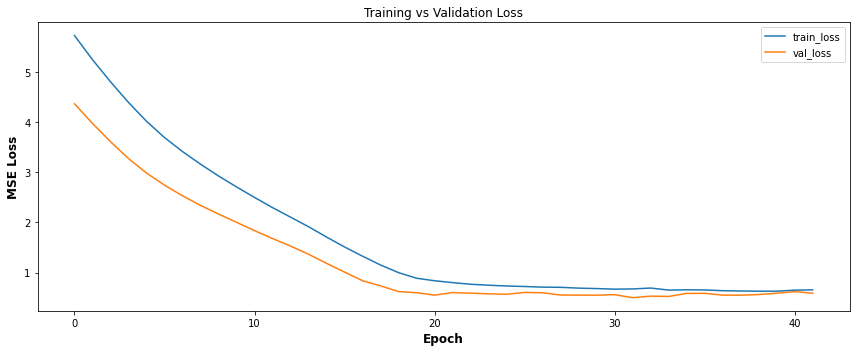

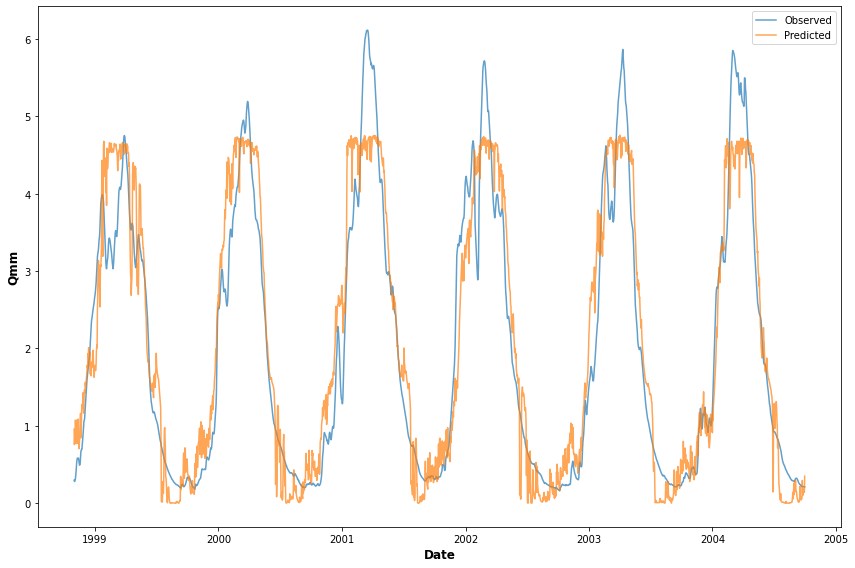

In [42]:
# Plot Training History & Predictions 
import matplotlib.pyplot as plt

# loss curve
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'],   label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch', fontsize=12, fontweight="bold")
plt.ylabel('MSE Loss', fontsize=12, fontweight="bold")
plt.title('Training vs Validation Loss')
plt.legend()
plt.tight_layout()
plt.show()

# timeseries prediction
dates_vl = val_data['date'].iloc[lb-1:]
plt.figure(figsize=(12,8))
plt.plot(dates_vl, y_vl,      label='Observed', alpha=0.7)
plt.plot(dates_vl, y_vl_pred, label='Predicted', alpha=0.7)
plt.xlabel('Date', fontsize=12, fontweight="bold")
plt.ylabel('Qmm', fontsize=12, fontweight="bold")
#plt.title(f'ID=31 Validation Prediction (lookback={lb})')
plt.legend()
plt.tight_layout()
plt.show()


In [61]:
best = {
    'lookback': 90,
    'units': 18,
    'lr': 0.0001,
    'dropout': 0.2
}
tag_best = f"lb{best['lookback']}_u{best['units']}_lr{best['lr']}_dp{best['dropout']}"
os.rename("y_vl_pred_best.npy", f"y_vl_pred_{tag_best}.npy")
os.rename("y_te_pred_best.npy", f"y_te_pred_{tag_best}.npy")
X_vl, y_vl = create_sequences(val_std, ALL_FEATURES, TARGET, 90)
np.save(f"y_vl_true_{tag_best}.npy", y_vl)

In [62]:
tag_best

'lb90_u18_lr0.0001_dp0.2'

### Here, I believe the peak was not well fitted, so I tried a set of values that were just slightly better than the optimal parameters.

In [47]:
# Define parameters + tag
params = {'lookback': 90, 'units': 24, 'lr': 0.001, 'dropout': 0.2}
tag = f"lb{params['lookback']}_u{params['units']}_lr{params['lr']}_dp{params['dropout']}"

# bulid model
model = make_model(params['lookback'], len(ALL_FEATURES), params['units'], params['dropout'], params['lr'])

ckpt_path = f"temp_{params['lookback']}_{params['units']}_{params['lr']}_{params['dropout']}_0.h5"
model.load_weights(ckpt_path)


In [48]:
X_vl, y_vl = create_sequences(val_std, ALL_FEATURES, TARGET, params['lookback'])
y_vl_pred = model.predict(X_vl).flatten()

np.save(f"y_vl_pred_{tag}.npy", y_vl_pred)


68/68 [==============================] - 1s 7ms/step


In [55]:
tag

'lb90_u24_lr0.001_dp0.2'

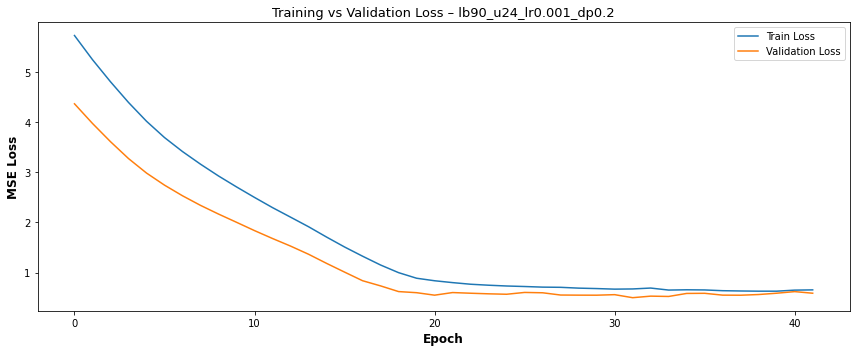

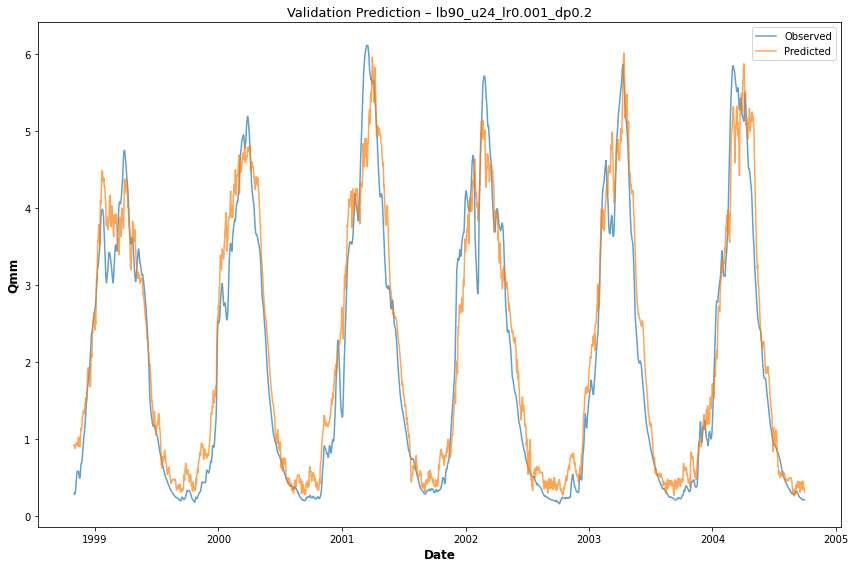

In [50]:
# loss
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', fontsize=12, fontweight="bold")
plt.ylabel('MSE Loss', fontsize=12, fontweight="bold")
plt.title(f'Training vs Validation Loss – {tag}', fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()

#Predicted vs. Actual Trend Chart
dates_vl = val_data['date'].iloc[params['lookback']-1:]
plt.figure(figsize=(12,8))
plt.plot(dates_vl, y_vl,      label='Observed', alpha=0.7)
plt.plot(dates_vl, y_vl_pred, label='Predicted', alpha=0.7)
plt.xlabel('Date', fontsize=12, fontweight="bold")
plt.ylabel('Qmm', fontsize=12, fontweight="bold")
plt.title(f'Validation Prediction – {tag}', fontsize=13)
plt.legend()
plt.tight_layout()
plt.show()

## 2.4 Compare the two parameters

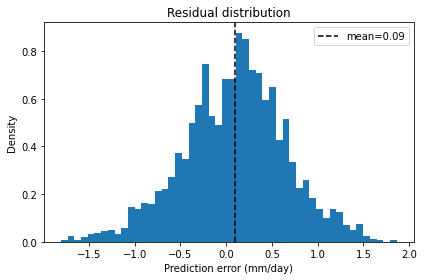

In [44]:
#tag1 = "lb90_u18_lr0.0001_dp0.2" 
resid = y_vl_pred - y_vl
plt.figure(figsize=(6,4))
plt.hist(resid, bins=50, density=True)
plt.axvline(resid.mean(), color='k', linestyle='--', label=f'mean={resid.mean():.2f}')
plt.xlabel('Prediction error (mm/day)')
plt.ylabel('Density')
plt.title('Residual distribution')
plt.legend()
plt.tight_layout()
plt.show()

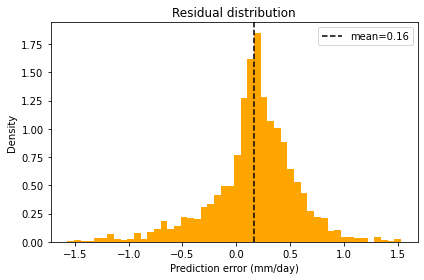

In [67]:
#tag2 = "lb90_u24_lr0.001_dp0.2" 
resid = y_vl_pred - y_vl
plt.figure(figsize=(6,4))
plt.hist(resid, bins=50, density=True, color='orange')  # 
plt.axvline(resid.mean(), color='k', linestyle='--', label=f'mean={resid.mean():.2f}')
plt.xlabel('Prediction error (mm/day)')
plt.ylabel('Density')
plt.title('Residual distribution')
plt.legend()
plt.tight_layout()
plt.show()

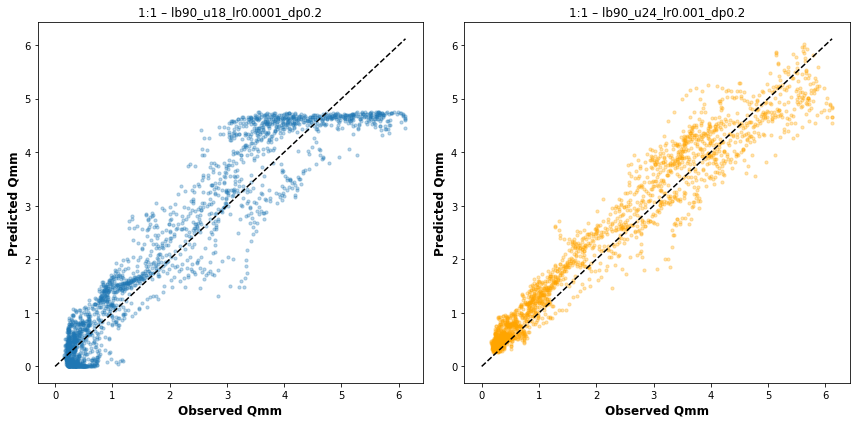

In [68]:
tag1 = "lb90_u18_lr0.0001_dp0.2"   # Best model
tag2 = "lb90_u24_lr0.001_dp0.2"   # Self-selected parameters model

#y_true
y_true = np.load(f"y_vl_true_{tag1}.npy")
y_pred_1 = np.load(f"y_vl_pred_{tag1}.npy")
y_pred_2 = np.load(f"y_vl_pred_{tag2}.npy")

# lpot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

#Best model
axs[0].scatter(y_true, y_pred_1, alpha=0.3, s=10)
lims = [0, max(y_true.max(), y_pred_1.max())]
axs[0].plot(lims, lims, 'k--')
axs[0].set_xlabel('Observed Qmm', fontsize=12, fontweight="bold")
axs[0].set_ylabel('Predicted Qmm', fontsize=12, fontweight="bold")
axs[0].set_title(f'1:1 – {tag1}')

# # Self-selected parameters model
axs[1].scatter(y_true, y_pred_2, alpha=0.3, s=10, color='orange')
lims = [0, max(y_true.max(), y_pred_2.max())]
axs[1].plot(lims, lims, 'k--')
axs[1].set_xlabel('Observed Qmm', fontsize=12, fontweight="bold")
axs[1].set_ylabel('Predicted Qmm', fontsize=12, fontweight="bold")
axs[1].set_title(f'1:1 – {tag2}')

plt.tight_layout()
plt.savefig(f"compare_1to1_{tag1}_vs_{tag2}.png", dpi=300)
plt.show()


| model  parameters    | KGE    | NSE    | CCC    |
| ----------- | ------ | ------ | ------ |
| u18\_lr1e-4 | 0.9089 | 0.9021 | 0.9445 |
| u24\_lr1e-3 | 0.9077 | 0.9054 | 0.9480 |

While the configuration lb90_u18_lr0.0001_dp0.2 achieved the highest KGE with centered residuals, the final model selected was lb90_u24_lr0.001_dp0.2. This choice was driven by its superior ability to track high-flow dynamics, especially peak discharge events, which are critical in the context of large river flow modeling.

Although the residuals showed a slight positive bias (mean ≈ +0.16), this is considered an acceptable and intentional trade-off, as it allows the LSTM model to better capture the amplitude of extreme flow variations. Given the study's focus on modeling and predicting large river flow dynamics—including peak flow characterization—the selected configuration provides a better compromise between statistical accuracy and hydrological relevance.

# 3.Incremental experimentation

In [2]:
def train_and_eval(X_tr, y_tr, X_vl, y_vl, input_dim):
    model = Sequential([
        LSTM(24, input_shape=(90, input_dim)),
        Dropout(0.2),
        Dense(1),
        Activation('relu')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    model.fit(X_tr, y_tr, validation_data=(X_vl, y_vl),
              epochs=50, batch_size=64, callbacks=[es], verbose=0)

    y_pred = model.predict(X_vl).flatten()
    kge = float(he.evaluator(he.kge, y_pred, y_vl)[0])
    nse = float(he.evaluator(he.nse, y_pred, y_vl)[0])
    ccc = concordance_correlation_coefficient(y_vl, y_pred)
    return kge, nse, ccc


In [16]:
feature_stages = {
    "A_dyn_only": ["prec_ref", "pet_pm"],
    "B_dyn+climate": ["prec_ref", "pet_pm", "clim_tmin", "clim_tmax", "clim_pmm", "clim_petmm_day", "aridity_index"],
    "C_dyn+hydro": ["prec_ref", "pet_pm", "q_mean_mm", "runoff_coef", "baseflow_index"],
    "D_dyn+landuse+human": ["prec_ref", "pet_pm", "cover_urban_%", "cover_crops_%", "res_number", "hdisturb_index"],
    "E_dyn+terrain": ["prec_ref", "pet_pm", "catch_area", "elev_mean", "catch_slope", "catch_order"],
    "F_all18": ALL_FEATURES
}

In [15]:
REPEATS = 3
LOOKBACK = 90
TARGET = "Qmm"
ablation_results = []

for stage_name, feats in feature_stages.items():
    print(f"\nStage: {stage_name} | Features: {len(feats)}")
    kge_list, nse_list, ccc_list = [], [], []

    for repeat in range(REPEATS):
        print(f"  Repeat {repeat+1}/{REPEATS}")
        train_subset = train_std[feats + [TARGET]].copy()
        val_subset   = val_std[feats + [TARGET]].copy()
        X_tr, y_tr = create_sequences(train_subset, feats, TARGET, LOOKBACK)
        X_vl, y_vl = create_sequences(val_subset,   feats, TARGET, LOOKBACK)
        kge, nse, ccc = train_and_eval(X_tr, y_tr, X_vl, y_vl, input_dim=len(feats))
        kge_list.append(kge)
        nse_list.append(nse)
        ccc_list.append(ccc)

    ablation_results.append({
        "Stage": stage_name,
        "n_features": len(feats),
        "Mean_KGE": np.mean(kge_list),
        "Std_KGE": np.std(kge_list),
        "Mean_NSE": np.mean(nse_list),
        "Std_NSE": np.std(nse_list),
        "Mean_CCC": np.mean(ccc_list),
        "Std_CCC": np.std(ccc_list)
    })

df_ablation = pd.DataFrame(ablation_results).set_index("Stage")
print(df_ablation)


Stage: A_dyn_only | Features: 2
  Repeat 1/3
68/68 [==============================] - 1s 7ms/step
  Repeat 2/3
68/68 [==============================] - 1s 7ms/step
  Repeat 3/3
68/68 [==============================] - 1s 8ms/step

Stage: B_dyn+climate | Features: 7
  Repeat 1/3
68/68 [==============================] - 1s 7ms/step
  Repeat 2/3
68/68 [==============================] - 1s 7ms/step
  Repeat 3/3
68/68 [==============================] - 1s 8ms/step

Stage: C_dyn+hydro | Features: 5
  Repeat 1/3
68/68 [==============================] - 1s 7ms/step
  Repeat 2/3
68/68 [==============================] - 1s 7ms/step
  Repeat 3/3
68/68 [==============================] - 1s 8ms/step

Stage: D_dyn+landuse+human | Features: 6
  Repeat 1/3
68/68 [==============================] - 1s 8ms/step
  Repeat 2/3
68/68 [==============================] - 1s 7ms/step
  Repeat 3/3
68/68 [==============================] - 1s 7ms/step

Stage: E_dyn+terrain | Features: 6
  Repeat 1/3
68/68 [=======

In [17]:
print(df_ablation[["Mean_KGE", "Mean_NSE", "Mean_CCC"]])

                     Mean_KGE  Mean_NSE  Mean_CCC
Stage                                            
A_dyn_only           0.896692  0.913184  0.958253
B_dyn+climate        0.890717  0.929364  0.965952
C_dyn+hydro          0.913189  0.925093  0.963278
D_dyn+landuse+human  0.894925  0.927649  0.964939
E_dyn+terrain        0.930436  0.932836  0.965664
F_all18              0.928294  0.916630  0.957684


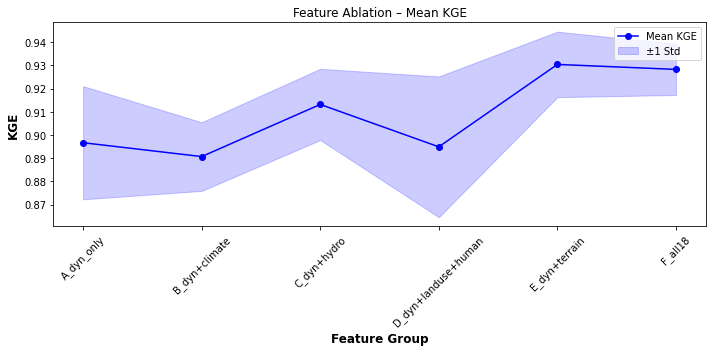

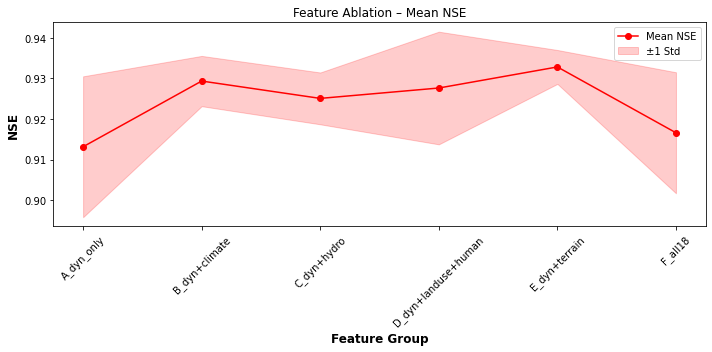

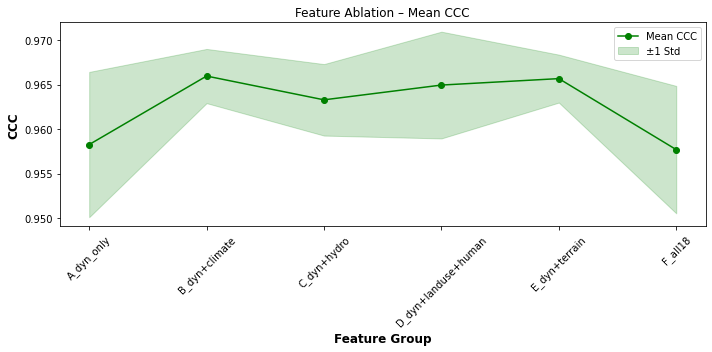

In [16]:

x_labels = df_ablation.index.tolist()
x_pos = np.arange(len(x_labels))

# KGE
plt.figure(figsize=(10, 5))
mean_vals = df_ablation["Mean_KGE"].values
std_vals = df_ablation["Std_KGE"].values

plt.plot(x_pos, mean_vals, marker='o', color='blue', label='Mean KGE')
plt.fill_between(x_pos, mean_vals - std_vals, mean_vals + std_vals, color='blue', alpha=0.2, label='±1 Std')
plt.xticks(x_pos, x_labels, rotation=45)
plt.title('Feature Ablation – Mean KGE')
plt.xlabel('Feature Group', fontsize=12, fontweight="bold")
plt.ylabel('KGE', fontsize=12, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()

#NSE 
plt.figure(figsize=(10, 5))
mean_vals = df_ablation["Mean_NSE"].values
std_vals = df_ablation["Std_NSE"].values

plt.plot(x_pos, mean_vals, marker='o', color='red', label='Mean NSE')
plt.fill_between(x_pos, mean_vals - std_vals, mean_vals + std_vals, color='red', alpha=0.2, label='±1 Std')
plt.xticks(x_pos, x_labels, rotation=45)
plt.title('Feature Ablation – Mean NSE')
plt.xlabel('Feature Group', fontsize=12, fontweight="bold")
plt.ylabel('NSE', fontsize=12, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()

#CCC 
plt.figure(figsize=(10, 5))
mean_vals = df_ablation["Mean_CCC"].values
std_vals = df_ablation["Std_CCC"].values

plt.plot(x_pos, mean_vals, marker='o', color='green', label='Mean CCC')
plt.fill_between(x_pos, mean_vals - std_vals, mean_vals + std_vals, color='green', alpha=0.2, label='±1 Std')
plt.xticks(x_pos, x_labels, rotation=45)
plt.title('Feature Ablation – Mean CCC')
plt.xlabel('Feature Group', fontsize=12, fontweight="bold")
plt.ylabel('CCC', fontsize=12, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()

# 4.Ablation experiment (removing variables one by one)


In [24]:
def run_leave_one_out_ablation(train_std, val_std, target, feature_group_name, feature_list, 
                               lookback=90, units=24, dropout=0.2, lr=0.001,
                               repeat=3, verbose=True):
    results = []

    if verbose:
        print(f"\nLeave-One-Out Ablation for group: {feature_group_name}")

    for drop_feat in feature_list:
        kept_feats = [f for f in feature_list if f != drop_feat]
        if verbose:
            print(f"\n Dropping: {drop_feat} | Keeping: {kept_feats}")

        kge_list, nse_list, ccc_list = [], [], []

        for r in range(repeat):
            train_subset = train_std[kept_feats + [target]].copy()
            val_subset = val_std[kept_feats + [target]].copy()

            X_tr, y_tr = create_sequences(train_subset, kept_feats, target, lookback)
            X_vl, y_vl = create_sequences(val_subset, kept_feats, target, lookback)

            model = Sequential([
                Input(shape=(lookback, len(kept_feats))),
                LSTM(units),
                Dropout(dropout),
                Dense(1),
                Activation('relu')
            ])
            model.compile(optimizer=Adam(learning_rate=lr), loss="mse")

            es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
            model.fit(X_tr, y_tr,
                      validation_data=(X_vl, y_vl),
                      epochs=50, batch_size=64,
                      callbacks=[es],
                      verbose=0)

            y_pred = model.predict(X_vl).flatten()
            kge = float(he.evaluator(he.kge, y_pred, y_vl)[0])
            nse = float(he.evaluator(he.nse, y_pred, y_vl)[0])
            ccc_val = concordance_correlation_coefficient(y_vl, y_pred)

            kge_list.append(kge)
            nse_list.append(nse)
            ccc_list.append(ccc_val)

        results.append({
            "Group": feature_group_name,
            "Dropped_Feature": drop_feat,
            "Kept_Features": ", ".join(kept_feats),
            "Mean_KGE": np.mean(kge_list), "Std_KGE": np.std(kge_list),
            "Mean_NSE": np.mean(nse_list), "Std_NSE": np.std(nse_list),
            "Mean_CCC": np.mean(ccc_list), "Std_CCC": np.std(ccc_list),
        })

    return pd.DataFrame(results)

def plot_leave_one_out_results(df_leaveone, score="Mean_KGE", group_name="Group", use_lineplot=True):
    df_sorted = df_leaveone.sort_values(by=score, ascending=False)

    plt.figure(figsize=(10, 5))
    if use_lineplot:
        plt.plot(df_sorted["Dropped_Feature"], df_sorted[score], marker='o', linestyle='-', color='darkorange')
    else:
        plt.bar(df_sorted["Dropped_Feature"], df_sorted[score], color="steelblue")

    plt.title(f"Leave-One-Out: {group_name} - {score}", fontsize=14)
    plt.xlabel("Dropped Feature")
    plt.ylabel(score)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 输出性能下降排名
    drop_impact = df_leaveone[score].max() - df_leaveone[score]
    df_rank = df_leaveone.copy()
    df_rank[f"{score}_DropImpact"] = drop_impact
    df_rank = df_rank.sort_values(by=f"{score}_DropImpact", ascending=False)

    return df_rank[["Dropped_Feature", score, f"{score}_DropImpact"]]



Leave-One-Out Ablation for group: E_dyn+terrain

 Dropping: prec_ref | Keeping: ['pet_pm', 'catch_area', 'elev_mean', 'catch_slope', 'catch_order']
68/68 [==============================] - 1s 8ms/step

 Dropping: pet_pm | Keeping: ['prec_ref', 'catch_area', 'elev_mean', 'catch_slope', 'catch_order']
68/68 [==============================] - 1s 8ms/step

 Dropping: catch_area | Keeping: ['prec_ref', 'pet_pm', 'elev_mean', 'catch_slope', 'catch_order']
68/68 [==============================] - 1s 8ms/step

 Dropping: elev_mean | Keeping: ['prec_ref', 'pet_pm', 'catch_area', 'catch_slope', 'catch_order']
68/68 [==============================] - 1s 8ms/step

 Dropping: catch_slope | Keeping: ['prec_ref', 'pet_pm', 'catch_area', 'elev_mean', 'catch_order']
68/68 [==============================] - 1s 8ms/step

 Dropping: catch_order | Keeping: ['prec_ref', 'pet_pm', 'catch_area', 'elev_mean', 'catch_slope']
68/68 [==============================] - 1s 8ms/step


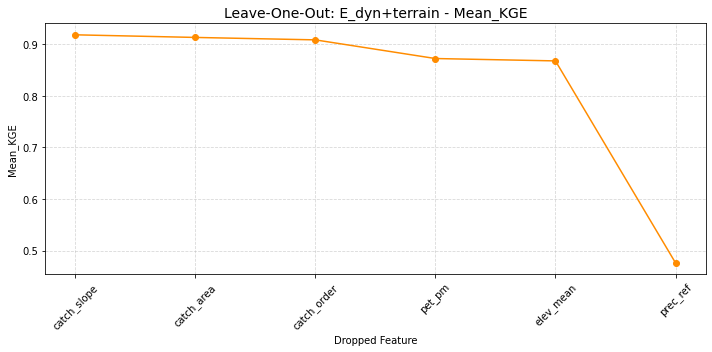

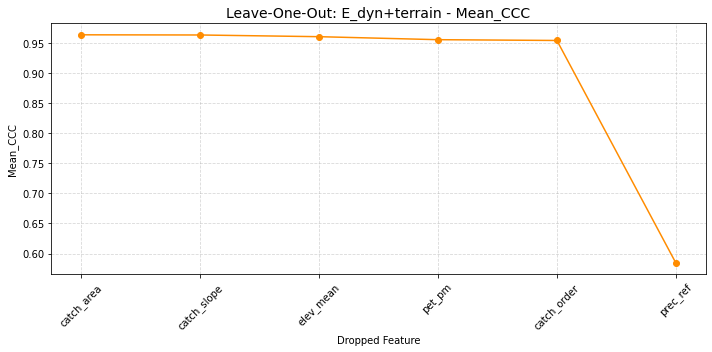

,Dropped_Feature,Mean_CCC,Mean_CCC_DropImpact
0,prec_ref,0.584390,0.378889
5,catch_order,0.953874,0.009404
1,pet_pm,0.955180,0.008099
3,elev_mean,0.960162,0.003116
4,catch_slope,0.962984,0.000295
2,catch_area,0.963278,0.000000


In [25]:
group_E = ["prec_ref", "pet_pm", "catch_area", "elev_mean", "catch_slope", "catch_order"]

df_loo_E = run_leave_one_out_ablation(train_std, val_std, "Qmm", "E_dyn+terrain", group_E)
df_loo_E["KGE_Drop"] = df_loo_E["Mean_KGE"].max() - df_loo_E["Mean_KGE"]
plot_leave_one_out_results(df_loo_E, score="Mean_KGE", group_name="E_dyn+terrain")
plot_leave_one_out_results(df_loo_E, score="Mean_CCC", group_name="E_dyn+terrain")

In [28]:
df_loo_E_sorted = df_loo_E.sort_values("KGE_Drop", ascending=False)

print(df_loo_E_sorted[["Dropped_Feature", "Mean_KGE", "KGE_Drop"]])

  Dropped_Feature  Mean_KGE  KGE_Drop
0        prec_ref  0.476072  0.442190
3       elev_mean  0.867684  0.050578
1          pet_pm  0.872287  0.045975
5     catch_order  0.908462  0.009800
2      catch_area  0.913189  0.005073
4     catch_slope  0.918262  0.000000


select  "prec_ref", "pet_pm","elev_mean"


Leave-One-Out Ablation for group: C_dyn+hydro

 Dropping: prec_ref | Keeping: ['pet_pm', 'q_mean_mm', 'runoff_coef', 'baseflow_index']
68/68 [==============================] - 1s 8ms/step

 Dropping: pet_pm | Keeping: ['prec_ref', 'q_mean_mm', 'runoff_coef', 'baseflow_index']
68/68 [==============================] - 1s 7ms/step

 Dropping: q_mean_mm | Keeping: ['prec_ref', 'pet_pm', 'runoff_coef', 'baseflow_index']
68/68 [==============================] - 1s 8ms/step

 Dropping: runoff_coef | Keeping: ['prec_ref', 'pet_pm', 'q_mean_mm', 'baseflow_index']
68/68 [==============================] - 1s 8ms/step

 Dropping: baseflow_index | Keeping: ['prec_ref', 'pet_pm', 'q_mean_mm', 'runoff_coef']
68/68 [==============================] - 1s 8ms/step


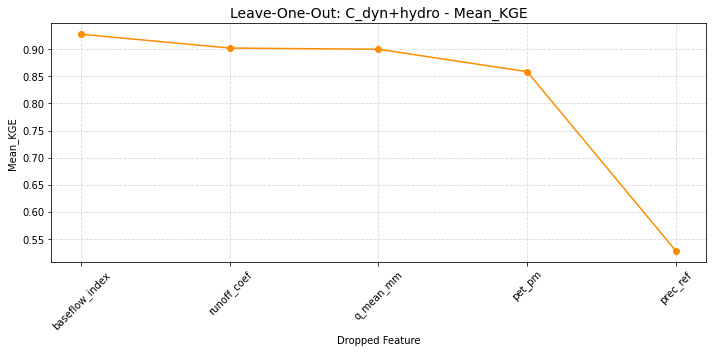

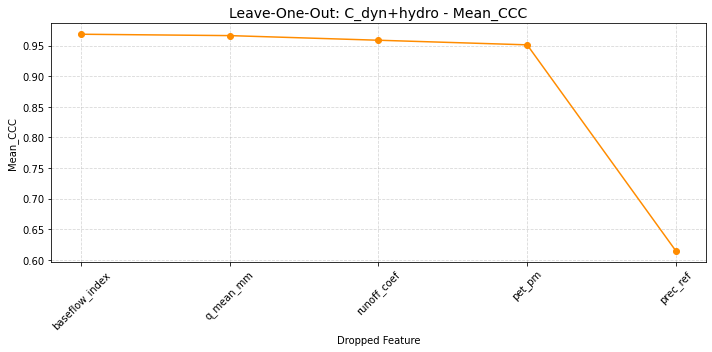

,Dropped_Feature,Mean_CCC,Mean_CCC_DropImpact
0,prec_ref,0.614468,0.354134
1,pet_pm,0.951257,0.017345
3,runoff_coef,0.958785,0.009817
2,q_mean_mm,0.966352,0.002250
4,baseflow_index,0.968602,0.000000


In [26]:
#"C_dyn+hydro"
group_C = ["prec_ref", "pet_pm", "q_mean_mm", "runoff_coef", "baseflow_index"]

df_loo_C = run_leave_one_out_ablation(train_std, val_std, "Qmm", "C_dyn+hydro", group_C)
df_loo_C["KGE_Drop"] = df_loo_C["Mean_KGE"].max() - df_loo_C["Mean_KGE"]
plot_leave_one_out_results(df_loo_C, score="Mean_KGE", group_name="C_dyn+hydro")
plot_leave_one_out_results(df_loo_C, score="Mean_CCC", group_name="C_dyn+hydro")

In [29]:
df_loo_C_sorted = df_loo_C.sort_values("KGE_Drop", ascending=False)

print(df_loo_C_sorted[["Dropped_Feature", "Mean_KGE", "KGE_Drop"]])

  Dropped_Feature  Mean_KGE  KGE_Drop
0        prec_ref  0.527558  0.400343
1          pet_pm  0.858714  0.069187
2       q_mean_mm  0.900126  0.027776
3     runoff_coef  0.902366  0.025535
4  baseflow_index  0.927901  0.000000


select "prec_ref", "pet_pm", "q_mean_mm"

# 5. Final model

In [31]:
FINAL_VARS = ["prec_ref", "pet_pm", "elev_mean", "q_mean_mm"]
print(f"\n Training final model with variables: {FINAL_VARS}")
LOOKBACK = 90
TARGET = "Qmm"

# 准备数据
train_final = train_std[FINAL_VARS + [TARGET]].copy()
val_final   = val_std[FINAL_VARS + [TARGET]].copy()
test_final  = test_std[FINAL_VARS + [TARGET]].copy()

X_train_final, y_train_final = create_sequences(train_final, FINAL_VARS, TARGET, LOOKBACK)
X_val_final,   y_val_final   = create_sequences(val_final, FINAL_VARS, TARGET, LOOKBACK)
X_test_final,  y_test_final  = create_sequences(test_final, FINAL_VARS, TARGET, LOOKBACK)

check_data(X_train_final, "X_train_final")
check_data(X_val_final, "X_val_final")
check_data(X_test_final, "X_test_final")


 Training final model with variables: ['prec_ref', 'pet_pm', 'elev_mean', 'q_mean_mm']
X_train_final passed check. Shape: (6485, 90, 4)
X_val_final passed check. Shape: (2162, 90, 4)
X_test_final passed check. Shape: (2161, 90, 4)


In [32]:
#build model
model_final = make_model(
    lookback=LOOKBACK,
    num_feats=len(FINAL_VARS),
    units=24,
    dp=0.2,
    lr=0.001
)

# Save path and training configuration
save_path = os.path.join(GLOBAL_OUTPUT_DIR, f"best_wts_FINAL4_u24_lr1e3_dp02_ID31_{LOOKBACK}d.h5")
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
ckpt = ModelCheckpoint(filepath=save_path, monitor="val_loss", save_best_only=True, save_weights_only=True)

print(f" Saving model to: {save_path}")

# train model
history_final = model_final.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=100,
    batch_size=128,
    callbacks=[es, ckpt],
    verbose=1
)

# Validation  Test
print("\n Final Model Evaluation:")
final_val_metrics = evaluate_model(model_final, X_val_final, y_val_final, name="Validation")
final_test_metrics = evaluate_model(model_final, X_test_final, y_test_final, name="Test")


 Saving model to: C:\Users\57484\Desktop\毕业设计 bristol\all_outputs\best_wts_FINAL4_u24_lr1e3_dp02_ID31_90d.h5
Epoch 1/100
51/51 [==============================] - 5s 53ms/step - loss: 6.0569 - mean_squared_error: 6.0569 - val_loss: 2.9071 - val_mean_squared_error: 2.9071
Epoch 2/100
51/51 [==============================] - 2s 38ms/step - loss: 2.6243 - mean_squared_error: 2.6243 - val_loss: 1.0194 - val_mean_squared_error: 1.0194
Epoch 3/100
51/51 [==============================] - 2s 37ms/step - loss: 0.9955 - mean_squared_error: 0.9955 - val_loss: 0.4312 - val_mean_squared_error: 0.4312
Epoch 4/100
51/51 [==============================] - 2s 40ms/step - loss: 0.6869 - mean_squared_error: 0.6869 - val_loss: 0.4211 - val_mean_squared_error: 0.4211
Epoch 5/100
51/51 [==============================] - 2s 38ms/step - loss: 0.6283 - mean_squared_error: 0.6283 - val_loss: 0.3114 - val_mean_squared_error: 0.3114
Epoch 6/100
51/51 [==============================] - 2s 38ms/step - loss: 0.6080 

68/68 [==============================] - 1s 7ms/step


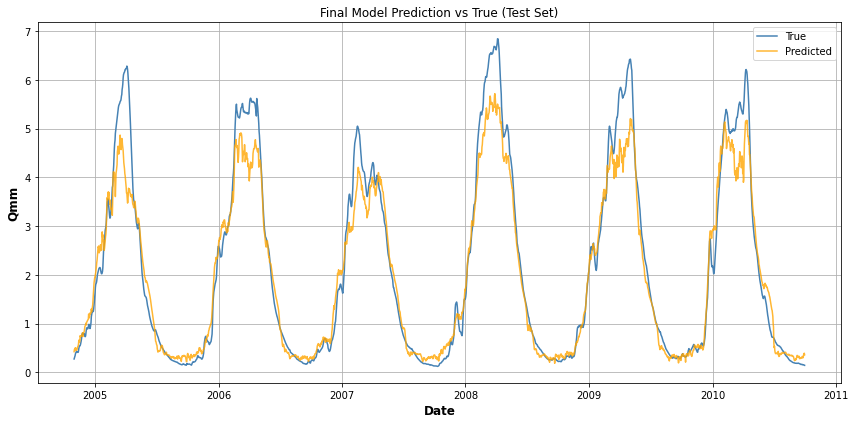

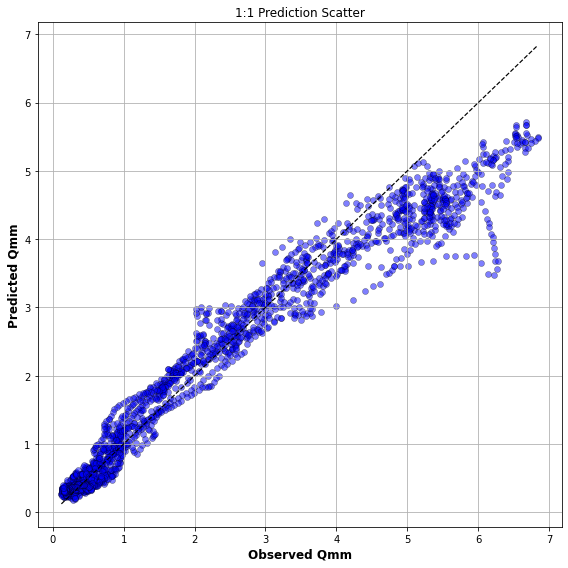

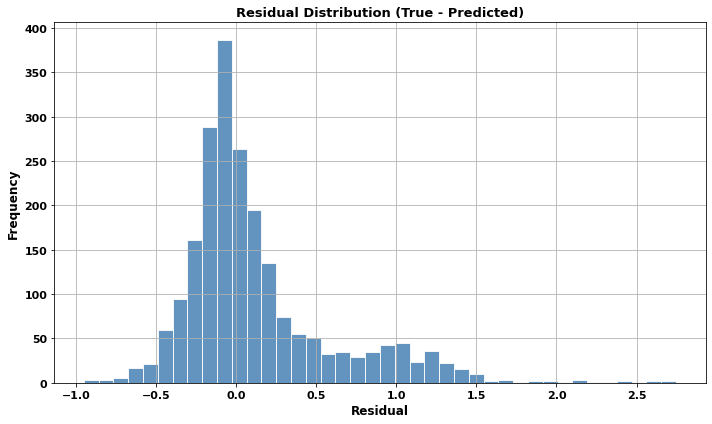

In [42]:
y_pred_test = model_final.predict(X_test_final).flatten()

#Align (take the corresponding length date of the last paragraph of test_std)
date_range = test_std["date"].iloc[-len(y_pred_test):].values
y_true_test = y_test_final

# Predicted vs. Actual Trend Chart
plt.figure(figsize=(12, 6))
plt.plot(date_range, y_true_test, label="True", color="steelblue")
plt.plot(date_range, y_pred_test, label="Predicted", color="orange", alpha=0.8)
plt.title("Final Model Prediction vs True (Test Set)")
plt.xlabel("Date",fontsize=12, fontweight='bold')
plt.ylabel("Qmm",fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "final4_trend_test.png"), dpi=300)
plt.show()

# 1:1 Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(y_true_test, y_pred_test, alpha=0.5, color="blue", edgecolors="black", linewidth=0.5)
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()],
         'k--', linewidth=1.2)
plt.xlabel("Observed Qmm",fontsize=12, fontweight='bold')
plt.ylabel("Predicted Qmm",fontsize=12, fontweight='bold')
plt.title("1:1 Prediction Scatter")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "final4_scatter_test.png"), dpi=300)
plt.show()


# Residual Distribution Chart
residuals = y_true_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=40,color='steelblue', edgecolor='white', alpha=0.85)
plt.title("Residual Distribution (True - Predicted)", fontsize=13, fontweight='bold')
plt.xlabel("Residual", fontsize=12, fontweight='bold')
plt.ylabel("Frequency", fontsize=12, fontweight='bold')
plt.xticks(fontsize=11, fontweight='bold')
plt.yticks(fontsize=11, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "final4_residuals_test.png"), dpi=300)
plt.show()



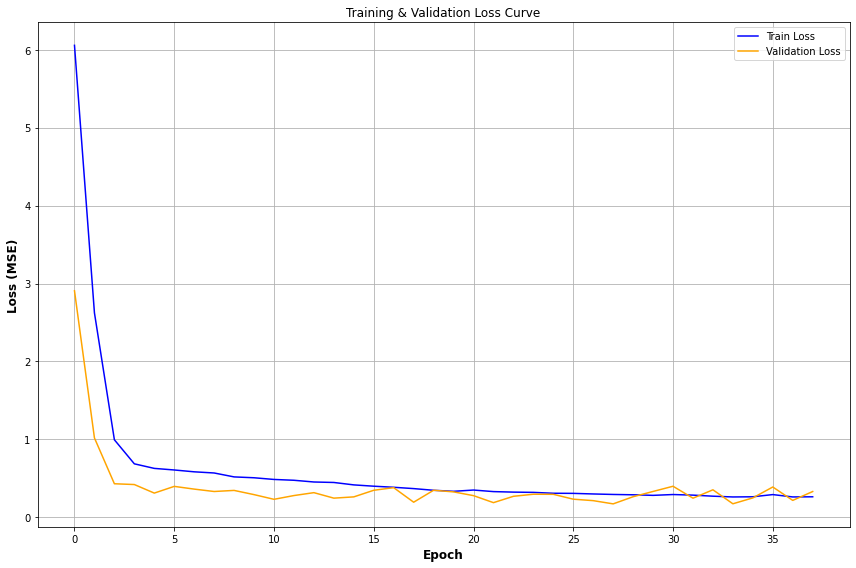

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(history_final.history['loss'], label='Train Loss', color='blue')
plt.plot(history_final.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel("Epoch" ,fontsize=12, fontweight='bold')
plt.ylabel("Loss (MSE)" ,fontsize=12, fontweight='bold')
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(GLOBAL_OUTPUT_DIR, "final4_loss_curve.png"))
plt.show()

In [48]:
df_pred = pd.DataFrame({
    "date": date_range,
    "Q_true": y_true_test,
    "Q_pred": y_pred_test,
    "residual": residuals
})
df_pred.to_csv(os.path.join(GLOBAL_OUTPUT_DIR, "final4_test_predictions.csv"), index=False)


In [49]:
config = {
    "features": FINAL_VARS,                      
    "lookback": LOOKBACK,                       
    "units": 24,                                 
    "dropout": 0.2,                              
    "learning_rate": 0.001,                      
    "target": TARGET,                            
    "model_path": "best_wts_FINAL4_u24_lr1e3_dp02_ID31_90d.h5" 
}

In [50]:
import joblib

joblib.dump(scaler, os.path.join(GLOBAL_OUTPUT_DIR, "scaler_final4.pkl"))

['C:\\Users\\57484\\Desktop\\毕业设计 bristol\\all_outputs\\scaler_final4.pkl']